# PixPi2x Evalutaion Notebook

## Importing Libraries

In [59]:
try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import DataLoader, Dataset
    import tqdm as tqdm
    from torchvision.utils import save_image, make_grid
    import albumentations as A
    from albumentations.pytorch import ToTensorV2
    import os
    import numpy as np
    from PIL import Image 
    from torchvision import datasets
    from Pix2Pix.generator_model import Generator
    import matplotlib.pyplot as plt
    %matplotlib inline
    print("Successfully imported all libraries")
except:
    print("Errors in importing libraries")


Successfully imported all libraries


## Downloading pre-trained models & sample testing images 

In [ ]:
!git clone https://github.com/ummadiviany/Pix2Pix

In [32]:
class MapDataset(Dataset):
    def __init__(self,root_dir,input_size):
        self.root_dir = root_dir
        self.input_size = input_size
        self.list_files = os.listdir(self.root_dir)

    def __len__(self):
        return len(self.list_files)

    def __getitem__(self,index):
        img_file = self.list_files[index]
        img_path = os.path.join(self.root_dir, img_file)
        image = np.array(Image.open(img_path))
        input_image = image[:,:self.input_size,:]
        target_image = image[:,self.input_size:,:]
        
        both_transform= A.Compose(
            [   
                A.Resize(width=256,height=256),
                A.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5],max_pixel_value=255.0),
                ToTensorV2()
            ]
        )
        input_image =  both_transform(image = input_image)['image']
        target_image = both_transform(image = target_image)['image']

        return input_image, target_image

In [33]:
IMG_DIR = "/notebooks/Pix2Pix/pix2pix-dataset/maps/maps/val"
INPUT_SIZE = 600
BATCH_SIZE = 4
train_dataset = MapDataset(root_dir= IMG_DIR,input_size=INPUT_SIZE)
train_loader = DataLoader(train_dataset,batch_size= BATCH_SIZE,shuffle=True)

In [48]:
input_images, target_images = next(iter(train_loader))

In [43]:


def get_model_for_eval(model_path):
  gen = Generator()
  model = torch.load(model_path)
  model_state = model['state_dict']
  gen.load_state_dict(model_state)
  return gen.eval()

In [45]:
model_path = '/notebooks/Pix2Pix/gen_maps.pth.tar'
gen = get_model_for_eval(model_path)


In [49]:
preds = gen(input_images)

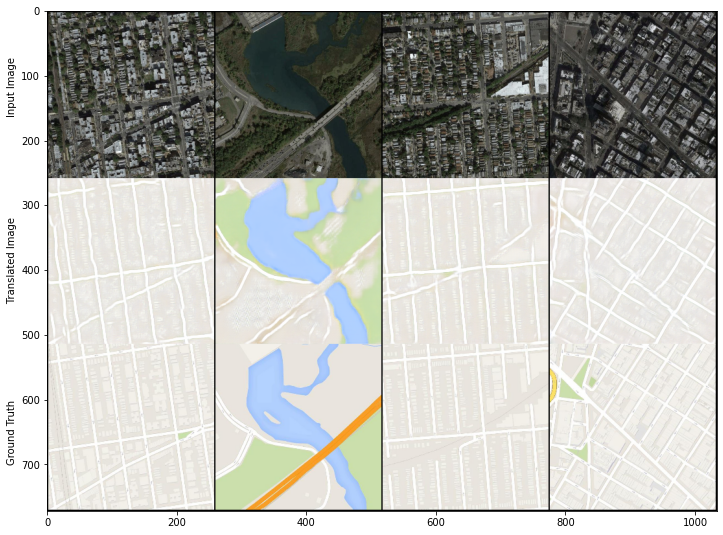

In [66]:
with torch.no_grad():
    res = torch.cat([input_images * 0.5 + 0.5,preds*0.5 + 0.5,target_images * 0.5 + 0.5,],dim=2)
    grid_img = make_grid(res)
    plt.figure(figsize=(12,16))
    plt.ylabel('Ground Truth                               Translated Image                                Input Image')
    plt.imshow(grid_img.permute(1, 2, 0))